In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
from medmnist import DermaMNIST
from captum.attr import GuidedGradCam, visualization as viz
import matplotlib.pyplot as plt
import numpy as np
import random
import optuna

In [17]:
# Ustawienie losowego ziarna dla powtarzalności wyników
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # Set your desired seed value here

# Funkcja celu dla Optuny
def objective(trial):
    # Hiperparametry do tuningu
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)
    # Hyperparameters and device setup
    # batch_size = 128
    epochs = 10
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 1. Wczytanie i przetwarzanie DermaMNIST
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.RandomAutocontrast(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.Normalize((0.5,), (0.5,))
    ])

    transform_test = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Data preparation
    train_dataset = DermaMNIST(root='./data', split="train", download=True, transform=transform_train, size=64)
    test_dataset = DermaMNIST(root='./data', split="test", download=True, transform=transform_test, size=64)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = models.resnet50(weights="IMAGENET1K_V1")
    # Freeze all the weights
    for param in model.parameters():
        param.requires_grad = False

    # Dostosowanie ostatnich warstw
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 128),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(128, 7)  # 7 klas w DermaMNIST
    )

    # Ensure the classifier's weights are trainable
    for param in model.fc.parameters():
        param.requires_grad = True

    model = model.to(device)

    # Funkcja kosztu i optymalizator
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

    # 3. Trenowanie modelu
    def train(model, train_loader, criterion, optimizer, device):
        model.train()
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            target = target.long()  # Zamień na torch.long
            if target.dim() > 1:    # Usuń nadmiarowe wymiary
                target = target.squeeze()

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        return running_loss / len(train_loader)

    # 4. Testowanie modelu
    def evaluate(model, test_loader, criterion, device):
        model.eval()
        test_loss = 0.0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                target = target.long()  # Zamień na torch.long
                if target.dim() > 1:    # Usuń nadmiarowe wymiary
                    target = target.squeeze()
                outputs = model(data)
                test_loss += criterion(outputs, target).item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == target).sum().item()
        test_loss /= len(test_loader)
        accuracy = correct / len(test_loader.dataset)
        return test_loss, accuracy

    # Training and testing loop
    train_losses = []
    test_losses = []
    accuracies = []
    patience = 3  # Early stopping patience
    best_test_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        test_loss, accuracy = evaluate(model, test_loader, criterion, device)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy*100:.2f}%")
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        accuracies.append(accuracy)
        # Check for improvement
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        else:
            patience_counter += 1

        # # Early stopping condition
        # if patience_counter >= patience:
        #     print(f"Early stopping at epoch {epoch+1}")
        #     break

    return 1 - accuracy  # Minimalizujemy 1 - accuracy

# Główna funkcja
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    study = optuna.create_study(direction="minimize")  # Minimalizacja (1 - accuracy)
    study.optimize(objective, n_trials=50)

    # Najlepsze hiperparametry
    print("Najlepsze hiperparametry: ", study.best_params)
    print("Najlepszy wynik: ", 1 - study.best_value)

[I 2025-01-26 01:33:40,152] A new study created in memory with name: no-name-3b600c6a-9160-4c92-adbb-553ca61e87df
C:\Users\Karolina\AppData\Local\Temp\ipykernel_31184\1773334994.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
C:\Users\Karolina\AppData\Local\Temp\ipykernel_31184\1773334994.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)


Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0857, Test Loss: 0.9992, Accuracy: 67.68%
Epoch [2/10], Train Loss: 0.9111, Test Loss: 0.9186, Accuracy: 68.88%
Epoch [3/10], Train Loss: 0.8722, Test Loss: 0.8881, Accuracy: 69.73%
Epoch [4/10], Train Loss: 0.8602, Test Loss: 0.8723, Accuracy: 70.42%
Epoch [5/10], Train Loss: 0.8335, Test Loss: 0.8490, Accuracy: 70.12%
Epoch [6/10], Train Loss: 0.8181, Test Loss: 0.8316, Accuracy: 70.42%
Epoch [7/10], Train Loss: 0.8286, Test Loss: 0.8416, Accuracy: 70.07%
Epoch [8/10], Train Loss: 0.8193, Test Loss: 0.8572, Accuracy: 69.68%
Epoch [9/10], Train Loss: 0.8059, Test Loss: 0.8104, Accuracy: 71.12%


[I 2025-01-26 01:35:08,350] Trial 0 finished with value: 0.3012468827930175 and parameters: {'batch_size': 128, 'learning_rate': 0.0007534933837767948, 'dropout_rate': 0.3110243910605888}. Best is trial 0 with value: 0.3012468827930175.


Epoch [10/10], Train Loss: 0.8010, Test Loss: 0.8172, Accuracy: 69.88%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.3245, Test Loss: 0.9909, Accuracy: 67.08%
Epoch [2/10], Train Loss: 0.9342, Test Loss: 0.9080, Accuracy: 69.28%
Epoch [3/10], Train Loss: 0.8777, Test Loss: 0.8897, Accuracy: 68.93%
Epoch [4/10], Train Loss: 0.8449, Test Loss: 0.8601, Accuracy: 69.08%
Epoch [5/10], Train Loss: 0.8419, Test Loss: 0.8737, Accuracy: 69.83%
Epoch [6/10], Train Loss: 0.8372, Test Loss: 0.8399, Accuracy: 69.78%
Epoch [7/10], Train Loss: 0.8341, Test Loss: 0.8345, Accuracy: 70.47%
Epoch [8/10], Train Loss: 0.8013, Test Loss: 0.8326, Accuracy: 70.02%
Epoch [9/10], Train Loss: 0.8090, Test Loss: 0.8100, Accuracy: 71.17%


[I 2025-01-26 01:36:33,759] Trial 1 finished with value: 0.313216957605985 and parameters: {'batch_size': 256, 'learning_rate': 0.003868809900227472, 'dropout_rate': 0.2234396542582438}. Best is trial 0 with value: 0.3012468827930175.


Epoch [10/10], Train Loss: 0.7954, Test Loss: 0.8653, Accuracy: 68.68%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0608, Test Loss: 0.9639, Accuracy: 68.33%
Epoch [2/10], Train Loss: 0.9266, Test Loss: 0.9729, Accuracy: 69.18%
Epoch [3/10], Train Loss: 0.8879, Test Loss: 0.8947, Accuracy: 69.33%
Epoch [4/10], Train Loss: 0.8753, Test Loss: 0.9122, Accuracy: 69.58%
Epoch [5/10], Train Loss: 0.8599, Test Loss: 0.8706, Accuracy: 70.47%
Epoch [6/10], Train Loss: 0.8505, Test Loss: 0.8736, Accuracy: 70.27%
Epoch [7/10], Train Loss: 0.8464, Test Loss: 0.8748, Accuracy: 69.88%
Epoch [8/10], Train Loss: 0.8320, Test Loss: 0.8557, Accuracy: 70.07%
Epoch [9/10], Train Loss: 0.8236, Test Loss: 0.8367, Accuracy: 71.12%


[I 2025-01-26 01:38:11,445] Trial 2 finished with value: 0.29675810473815456 and parameters: {'batch_size': 32, 'learning_rate': 0.00021048309836935755, 'dropout_rate': 0.4220624987811147}. Best is trial 2 with value: 0.29675810473815456.


Epoch [10/10], Train Loss: 0.8184, Test Loss: 0.9039, Accuracy: 70.32%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0118, Test Loss: 0.9403, Accuracy: 68.68%
Epoch [2/10], Train Loss: 0.8888, Test Loss: 0.8980, Accuracy: 69.93%
Epoch [3/10], Train Loss: 0.8710, Test Loss: 0.9194, Accuracy: 68.68%
Epoch [4/10], Train Loss: 0.8501, Test Loss: 0.8855, Accuracy: 69.93%
Epoch [5/10], Train Loss: 0.8539, Test Loss: 0.9407, Accuracy: 69.03%
Epoch [6/10], Train Loss: 0.8456, Test Loss: 0.8919, Accuracy: 69.23%
Epoch [7/10], Train Loss: 0.8336, Test Loss: 0.8683, Accuracy: 69.68%
Epoch [8/10], Train Loss: 0.8257, Test Loss: 0.8528, Accuracy: 70.07%
Epoch [9/10], Train Loss: 0.8177, Test Loss: 0.8456, Accuracy: 70.47%


[I 2025-01-26 01:39:42,846] Trial 3 finished with value: 0.28079800498753116 and parameters: {'batch_size': 64, 'learning_rate': 0.001835420071451186, 'dropout_rate': 0.2615251891081807}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8151, Test Loss: 0.7947, Accuracy: 71.92%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.1425, Test Loss: 1.1461, Accuracy: 67.18%
Epoch [2/10], Train Loss: 0.9876, Test Loss: 0.9792, Accuracy: 68.18%
Epoch [3/10], Train Loss: 0.9802, Test Loss: 0.9326, Accuracy: 67.73%
Epoch [4/10], Train Loss: 0.9740, Test Loss: 0.9835, Accuracy: 66.88%
Epoch [5/10], Train Loss: 0.9696, Test Loss: 1.0233, Accuracy: 67.38%
Epoch [6/10], Train Loss: 0.9789, Test Loss: 0.9659, Accuracy: 68.23%
Epoch [7/10], Train Loss: 0.9692, Test Loss: 1.0887, Accuracy: 67.18%
Epoch [8/10], Train Loss: 0.9714, Test Loss: 0.9039, Accuracy: 66.33%
Epoch [9/10], Train Loss: 0.9739, Test Loss: 0.9907, Accuracy: 67.73%


[I 2025-01-26 01:41:18,756] Trial 4 finished with value: 0.32119700748129676 and parameters: {'batch_size': 32, 'learning_rate': 0.008280949887210154, 'dropout_rate': 0.24708432807682762}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.9703, Test Loss: 0.9294, Accuracy: 67.88%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.1041, Test Loss: 0.9976, Accuracy: 67.68%
Epoch [2/10], Train Loss: 0.9214, Test Loss: 0.9519, Accuracy: 68.43%
Epoch [3/10], Train Loss: 0.8920, Test Loss: 0.9217, Accuracy: 68.93%
Epoch [4/10], Train Loss: 0.8550, Test Loss: 0.8903, Accuracy: 69.98%
Epoch [5/10], Train Loss: 0.8512, Test Loss: 0.8819, Accuracy: 69.38%
Epoch [6/10], Train Loss: 0.8315, Test Loss: 0.8706, Accuracy: 69.38%
Epoch [7/10], Train Loss: 0.8224, Test Loss: 0.8416, Accuracy: 70.57%
Epoch [8/10], Train Loss: 0.8159, Test Loss: 0.8209, Accuracy: 70.77%
Epoch [9/10], Train Loss: 0.8032, Test Loss: 0.8425, Accuracy: 70.72%


[I 2025-01-26 01:42:43,311] Trial 5 finished with value: 0.2887780548628429 and parameters: {'batch_size': 128, 'learning_rate': 0.0005066253234206965, 'dropout_rate': 0.3174229738119736}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8006, Test Loss: 0.8246, Accuracy: 71.12%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 0.9986, Test Loss: 0.9709, Accuracy: 68.23%
Epoch [2/10], Train Loss: 0.8761, Test Loss: 0.8793, Accuracy: 69.78%
Epoch [3/10], Train Loss: 0.8617, Test Loss: 0.9225, Accuracy: 68.78%
Epoch [4/10], Train Loss: 0.8341, Test Loss: 0.8359, Accuracy: 70.72%
Epoch [5/10], Train Loss: 0.8280, Test Loss: 0.8434, Accuracy: 70.52%
Epoch [6/10], Train Loss: 0.8241, Test Loss: 0.8343, Accuracy: 70.72%
Epoch [7/10], Train Loss: 0.8130, Test Loss: 0.8693, Accuracy: 69.73%
Epoch [8/10], Train Loss: 0.8073, Test Loss: 0.8496, Accuracy: 70.77%
Epoch [9/10], Train Loss: 0.7916, Test Loss: 0.7923, Accuracy: 71.47%


[I 2025-01-26 01:44:12,623] Trial 6 finished with value: 0.28428927680798 and parameters: {'batch_size': 64, 'learning_rate': 0.0009027940491257541, 'dropout_rate': 0.21956728775009055}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.7951, Test Loss: 0.7973, Accuracy: 71.57%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.1203, Test Loss: 0.9973, Accuracy: 67.73%
Epoch [2/10], Train Loss: 0.9235, Test Loss: 0.9145, Accuracy: 69.73%
Epoch [3/10], Train Loss: 0.8954, Test Loss: 0.9139, Accuracy: 68.23%
Epoch [4/10], Train Loss: 0.8535, Test Loss: 0.8735, Accuracy: 69.08%
Epoch [5/10], Train Loss: 0.8273, Test Loss: 0.8797, Accuracy: 70.07%
Epoch [6/10], Train Loss: 0.8378, Test Loss: 0.8594, Accuracy: 69.48%
Epoch [7/10], Train Loss: 0.8227, Test Loss: 0.8639, Accuracy: 68.98%
Epoch [8/10], Train Loss: 0.8145, Test Loss: 0.8151, Accuracy: 70.82%
Epoch [9/10], Train Loss: 0.7863, Test Loss: 0.8478, Accuracy: 69.98%


[I 2025-01-26 01:45:35,423] Trial 7 finished with value: 0.2932668329177057 and parameters: {'batch_size': 256, 'learning_rate': 0.0011206417198263011, 'dropout_rate': 0.29477834592234875}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.7935, Test Loss: 0.8240, Accuracy: 70.67%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 0.9893, Test Loss: 1.0092, Accuracy: 68.18%
Epoch [2/10], Train Loss: 0.8802, Test Loss: 0.9456, Accuracy: 69.28%
Epoch [3/10], Train Loss: 0.8525, Test Loss: 0.9014, Accuracy: 69.63%
Epoch [4/10], Train Loss: 0.8394, Test Loss: 0.8344, Accuracy: 71.22%
Epoch [5/10], Train Loss: 0.8329, Test Loss: 0.8337, Accuracy: 70.82%
Epoch [6/10], Train Loss: 0.8270, Test Loss: 0.8906, Accuracy: 70.37%
Epoch [7/10], Train Loss: 0.8189, Test Loss: 0.8321, Accuracy: 71.62%
Epoch [8/10], Train Loss: 0.8168, Test Loss: 0.8144, Accuracy: 71.02%
Epoch [9/10], Train Loss: 0.8042, Test Loss: 0.8272, Accuracy: 71.62%


[I 2025-01-26 01:47:10,214] Trial 8 finished with value: 0.29226932668329175 and parameters: {'batch_size': 32, 'learning_rate': 0.0005824936363789449, 'dropout_rate': 0.2072376881077322}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.7985, Test Loss: 0.8186, Accuracy: 70.77%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0274, Test Loss: 0.9372, Accuracy: 68.83%
Epoch [2/10], Train Loss: 0.8969, Test Loss: 0.9425, Accuracy: 67.73%
Epoch [3/10], Train Loss: 0.8607, Test Loss: 0.8906, Accuracy: 69.53%
Epoch [4/10], Train Loss: 0.8475, Test Loss: 0.8858, Accuracy: 69.93%
Epoch [5/10], Train Loss: 0.8248, Test Loss: 0.8250, Accuracy: 71.32%
Epoch [6/10], Train Loss: 0.8344, Test Loss: 0.8402, Accuracy: 70.72%
Epoch [7/10], Train Loss: 0.8322, Test Loss: 0.8761, Accuracy: 70.32%
Epoch [8/10], Train Loss: 0.8146, Test Loss: 0.8685, Accuracy: 69.98%
Epoch [9/10], Train Loss: 0.8226, Test Loss: 0.8019, Accuracy: 71.27%


[I 2025-01-26 01:48:38,120] Trial 9 finished with value: 0.2917705735660848 and parameters: {'batch_size': 64, 'learning_rate': 0.0008485286333812673, 'dropout_rate': 0.3625444658566699}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.7993, Test Loss: 0.8314, Accuracy: 70.82%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0560, Test Loss: 0.9713, Accuracy: 67.83%
Epoch [2/10], Train Loss: 0.9389, Test Loss: 0.9375, Accuracy: 67.98%
Epoch [3/10], Train Loss: 0.9215, Test Loss: 0.9173, Accuracy: 68.73%
Epoch [4/10], Train Loss: 0.9168, Test Loss: 0.8936, Accuracy: 68.93%
Epoch [5/10], Train Loss: 0.9248, Test Loss: 0.9445, Accuracy: 67.93%
Epoch [6/10], Train Loss: 0.8967, Test Loss: 0.9709, Accuracy: 68.03%
Epoch [7/10], Train Loss: 0.8760, Test Loss: 0.8660, Accuracy: 67.93%
Epoch [8/10], Train Loss: 0.8805, Test Loss: 0.9638, Accuracy: 68.88%
Epoch [9/10], Train Loss: 0.8910, Test Loss: 0.8784, Accuracy: 69.48%


[I 2025-01-26 01:50:05,916] Trial 10 finished with value: 0.3072319201995013 and parameters: {'batch_size': 64, 'learning_rate': 0.0024829522384965815, 'dropout_rate': 0.47898270520179836}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8876, Test Loss: 0.8362, Accuracy: 69.28%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0133, Test Loss: 0.9176, Accuracy: 69.43%
Epoch [2/10], Train Loss: 0.8889, Test Loss: 0.9203, Accuracy: 68.38%
Epoch [3/10], Train Loss: 0.8726, Test Loss: 0.8693, Accuracy: 68.83%
Epoch [4/10], Train Loss: 0.8526, Test Loss: 0.8483, Accuracy: 69.83%
Epoch [5/10], Train Loss: 0.8421, Test Loss: 0.8391, Accuracy: 70.47%
Epoch [6/10], Train Loss: 0.8377, Test Loss: 0.9148, Accuracy: 69.43%
Epoch [7/10], Train Loss: 0.8272, Test Loss: 0.8946, Accuracy: 70.07%
Epoch [8/10], Train Loss: 0.8171, Test Loss: 0.8402, Accuracy: 70.87%
Epoch [9/10], Train Loss: 0.8288, Test Loss: 0.8200, Accuracy: 71.72%


[I 2025-01-26 01:51:33,613] Trial 11 finished with value: 0.29226932668329175 and parameters: {'batch_size': 64, 'learning_rate': 0.00184253503628532, 'dropout_rate': 0.25961651937218455}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8083, Test Loss: 0.8185, Accuracy: 70.77%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0480, Test Loss: 1.0038, Accuracy: 67.43%
Epoch [2/10], Train Loss: 0.9106, Test Loss: 0.9406, Accuracy: 69.83%
Epoch [3/10], Train Loss: 0.8677, Test Loss: 0.8954, Accuracy: 70.22%
Epoch [4/10], Train Loss: 0.8362, Test Loss: 0.8791, Accuracy: 70.37%
Epoch [5/10], Train Loss: 0.8275, Test Loss: 0.8748, Accuracy: 69.98%
Epoch [6/10], Train Loss: 0.8110, Test Loss: 0.9157, Accuracy: 69.53%
Epoch [7/10], Train Loss: 0.8163, Test Loss: 0.8512, Accuracy: 70.97%
Epoch [8/10], Train Loss: 0.7998, Test Loss: 0.8327, Accuracy: 70.72%
Epoch [9/10], Train Loss: 0.7939, Test Loss: 0.8294, Accuracy: 70.57%


[I 2025-01-26 01:53:02,441] Trial 12 finished with value: 0.28229426433915217 and parameters: {'batch_size': 64, 'learning_rate': 0.000238237597382847, 'dropout_rate': 0.20313316849286467}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.7875, Test Loss: 0.8050, Accuracy: 71.77%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.1140, Test Loss: 1.0605, Accuracy: 67.18%
Epoch [2/10], Train Loss: 0.9601, Test Loss: 1.0037, Accuracy: 67.98%
Epoch [3/10], Train Loss: 0.9054, Test Loss: 0.9295, Accuracy: 69.23%
Epoch [4/10], Train Loss: 0.8838, Test Loss: 0.9208, Accuracy: 69.08%
Epoch [5/10], Train Loss: 0.8642, Test Loss: 0.9054, Accuracy: 69.78%
Epoch [6/10], Train Loss: 0.8494, Test Loss: 0.9077, Accuracy: 69.83%
Epoch [7/10], Train Loss: 0.8417, Test Loss: 0.9151, Accuracy: 69.23%
Epoch [8/10], Train Loss: 0.8307, Test Loss: 0.9012, Accuracy: 69.38%
Epoch [9/10], Train Loss: 0.8262, Test Loss: 0.8818, Accuracy: 69.98%


[I 2025-01-26 01:54:31,438] Trial 13 finished with value: 0.30523690773067336 and parameters: {'batch_size': 64, 'learning_rate': 0.00011048227062507015, 'dropout_rate': 0.2692003334641853}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8150, Test Loss: 0.9037, Accuracy: 69.48%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0722, Test Loss: 0.9778, Accuracy: 68.58%
Epoch [2/10], Train Loss: 0.9165, Test Loss: 0.9760, Accuracy: 68.13%
Epoch [3/10], Train Loss: 0.8723, Test Loss: 0.8876, Accuracy: 69.98%
Epoch [4/10], Train Loss: 0.8590, Test Loss: 0.8916, Accuracy: 69.78%
Epoch [5/10], Train Loss: 0.8267, Test Loss: 0.9163, Accuracy: 69.03%
Epoch [6/10], Train Loss: 0.8400, Test Loss: 0.8558, Accuracy: 70.27%
Epoch [7/10], Train Loss: 0.8279, Test Loss: 0.8662, Accuracy: 70.77%
Epoch [8/10], Train Loss: 0.8109, Test Loss: 0.8412, Accuracy: 70.77%
Epoch [9/10], Train Loss: 0.8053, Test Loss: 0.8393, Accuracy: 70.62%


[I 2025-01-26 01:55:57,228] Trial 14 finished with value: 0.2942643391521197 and parameters: {'batch_size': 64, 'learning_rate': 0.0002560072265943083, 'dropout_rate': 0.368273724326044}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8087, Test Loss: 0.8477, Accuracy: 70.57%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0480, Test Loss: 0.9644, Accuracy: 68.48%
Epoch [2/10], Train Loss: 0.9043, Test Loss: 0.9564, Accuracy: 68.53%
Epoch [3/10], Train Loss: 0.8638, Test Loss: 0.8823, Accuracy: 70.07%
Epoch [4/10], Train Loss: 0.8495, Test Loss: 0.8760, Accuracy: 69.43%
Epoch [5/10], Train Loss: 0.8345, Test Loss: 0.8527, Accuracy: 70.07%
Epoch [6/10], Train Loss: 0.8217, Test Loss: 0.8739, Accuracy: 69.98%
Epoch [7/10], Train Loss: 0.8022, Test Loss: 0.8209, Accuracy: 71.47%
Epoch [8/10], Train Loss: 0.8106, Test Loss: 0.8313, Accuracy: 69.93%
Epoch [9/10], Train Loss: 0.7996, Test Loss: 0.8125, Accuracy: 72.32%


[I 2025-01-26 01:57:24,620] Trial 15 finished with value: 0.29376558603491276 and parameters: {'batch_size': 64, 'learning_rate': 0.0002821937710875259, 'dropout_rate': 0.28093605619154155}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8004, Test Loss: 0.8205, Accuracy: 70.62%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.2188, Test Loss: 0.9859, Accuracy: 68.68%
Epoch [2/10], Train Loss: 0.9354, Test Loss: 0.9254, Accuracy: 68.68%
Epoch [3/10], Train Loss: 0.9102, Test Loss: 0.8893, Accuracy: 68.68%
Epoch [4/10], Train Loss: 0.9095, Test Loss: 0.8950, Accuracy: 68.33%
Epoch [5/10], Train Loss: 0.9005, Test Loss: 0.9124, Accuracy: 68.18%
Epoch [6/10], Train Loss: 0.8821, Test Loss: 0.9937, Accuracy: 68.43%
Epoch [7/10], Train Loss: 0.9017, Test Loss: 0.8576, Accuracy: 68.98%
Epoch [8/10], Train Loss: 0.8815, Test Loss: 0.8659, Accuracy: 67.98%
Epoch [9/10], Train Loss: 0.8803, Test Loss: 0.9133, Accuracy: 67.88%


[I 2025-01-26 01:58:53,261] Trial 16 finished with value: 0.31820448877805485 and parameters: {'batch_size': 64, 'learning_rate': 0.007026014358221818, 'dropout_rate': 0.2055290416962225}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8810, Test Loss: 0.8910, Accuracy: 68.18%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.2463, Test Loss: 1.1115, Accuracy: 66.88%
Epoch [2/10], Train Loss: 1.0560, Test Loss: 1.0425, Accuracy: 66.93%
Epoch [3/10], Train Loss: 0.9761, Test Loss: 0.9796, Accuracy: 68.13%
Epoch [4/10], Train Loss: 0.9460, Test Loss: 0.9474, Accuracy: 68.13%
Epoch [5/10], Train Loss: 0.9143, Test Loss: 0.9286, Accuracy: 68.93%
Epoch [6/10], Train Loss: 0.8957, Test Loss: 0.9052, Accuracy: 69.58%
Epoch [7/10], Train Loss: 0.8802, Test Loss: 0.9018, Accuracy: 69.73%
Epoch [8/10], Train Loss: 0.8762, Test Loss: 0.8919, Accuracy: 69.68%
Epoch [9/10], Train Loss: 0.8583, Test Loss: 0.8906, Accuracy: 69.88%


[I 2025-01-26 02:00:17,567] Trial 17 finished with value: 0.3072319201995013 and parameters: {'batch_size': 128, 'learning_rate': 0.00011987678635520952, 'dropout_rate': 0.40314882477432995}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8647, Test Loss: 0.9030, Accuracy: 69.28%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.1249, Test Loss: 0.9721, Accuracy: 67.58%
Epoch [2/10], Train Loss: 0.9125, Test Loss: 0.9037, Accuracy: 69.28%
Epoch [3/10], Train Loss: 0.8707, Test Loss: 0.8780, Accuracy: 69.58%
Epoch [4/10], Train Loss: 0.8600, Test Loss: 0.8593, Accuracy: 70.32%
Epoch [5/10], Train Loss: 0.8398, Test Loss: 0.8480, Accuracy: 69.58%
Epoch [6/10], Train Loss: 0.8297, Test Loss: 0.8368, Accuracy: 70.07%
Epoch [7/10], Train Loss: 0.8189, Test Loss: 0.8209, Accuracy: 70.62%
Epoch [8/10], Train Loss: 0.8066, Test Loss: 0.8199, Accuracy: 70.47%
Epoch [9/10], Train Loss: 0.8023, Test Loss: 0.8549, Accuracy: 69.93%


[I 2025-01-26 02:01:41,370] Trial 18 finished with value: 0.28778054862842894 and parameters: {'batch_size': 256, 'learning_rate': 0.0017703948625823144, 'dropout_rate': 0.3340729184117653}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8032, Test Loss: 0.8185, Accuracy: 71.22%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0439, Test Loss: 0.9780, Accuracy: 67.93%
Epoch [2/10], Train Loss: 0.8995, Test Loss: 0.9413, Accuracy: 69.58%
Epoch [3/10], Train Loss: 0.8614, Test Loss: 0.9566, Accuracy: 68.28%
Epoch [4/10], Train Loss: 0.8422, Test Loss: 0.8524, Accuracy: 70.72%
Epoch [5/10], Train Loss: 0.8321, Test Loss: 0.8485, Accuracy: 70.52%
Epoch [6/10], Train Loss: 0.8159, Test Loss: 0.8397, Accuracy: 70.37%
Epoch [7/10], Train Loss: 0.8155, Test Loss: 0.8230, Accuracy: 71.22%
Epoch [8/10], Train Loss: 0.7987, Test Loss: 0.8135, Accuracy: 72.07%
Epoch [9/10], Train Loss: 0.7949, Test Loss: 0.8124, Accuracy: 71.62%


[I 2025-01-26 02:03:11,186] Trial 19 finished with value: 0.2827930174563591 and parameters: {'batch_size': 64, 'learning_rate': 0.0004140885278827097, 'dropout_rate': 0.24755793179846441}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8028, Test Loss: 0.8108, Accuracy: 71.72%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.1140, Test Loss: 0.9605, Accuracy: 68.08%
Epoch [2/10], Train Loss: 0.9245, Test Loss: 0.9071, Accuracy: 68.48%
Epoch [3/10], Train Loss: 0.8915, Test Loss: 0.8870, Accuracy: 69.73%
Epoch [4/10], Train Loss: 0.8967, Test Loss: 0.9242, Accuracy: 69.28%
Epoch [5/10], Train Loss: 0.8972, Test Loss: 0.8756, Accuracy: 68.98%
Epoch [6/10], Train Loss: 0.8658, Test Loss: 0.8656, Accuracy: 69.43%
Epoch [7/10], Train Loss: 0.8761, Test Loss: 0.8580, Accuracy: 70.17%
Epoch [8/10], Train Loss: 0.8748, Test Loss: 0.8369, Accuracy: 70.22%
Epoch [9/10], Train Loss: 0.8446, Test Loss: 0.8696, Accuracy: 69.43%


[I 2025-01-26 02:04:39,110] Trial 20 finished with value: 0.31221945137157103 and parameters: {'batch_size': 64, 'learning_rate': 0.004735762645956773, 'dropout_rate': 0.24177370036994672}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8622, Test Loss: 0.9160, Accuracy: 68.78%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0439, Test Loss: 0.9657, Accuracy: 68.28%
Epoch [2/10], Train Loss: 0.8992, Test Loss: 0.9682, Accuracy: 69.58%
Epoch [3/10], Train Loss: 0.8628, Test Loss: 0.9138, Accuracy: 69.38%
Epoch [4/10], Train Loss: 0.8479, Test Loss: 0.8591, Accuracy: 70.77%
Epoch [5/10], Train Loss: 0.8289, Test Loss: 0.8635, Accuracy: 69.58%
Epoch [6/10], Train Loss: 0.8193, Test Loss: 0.8350, Accuracy: 70.52%
Epoch [7/10], Train Loss: 0.8142, Test Loss: 0.8230, Accuracy: 71.32%
Epoch [8/10], Train Loss: 0.8113, Test Loss: 0.8317, Accuracy: 71.02%
Epoch [9/10], Train Loss: 0.7921, Test Loss: 0.8481, Accuracy: 69.88%


[I 2025-01-26 02:06:06,474] Trial 21 finished with value: 0.2902743142144638 and parameters: {'batch_size': 64, 'learning_rate': 0.00042172342990639373, 'dropout_rate': 0.24688053823402714}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.7896, Test Loss: 0.8388, Accuracy: 70.97%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0654, Test Loss: 0.9974, Accuracy: 67.63%
Epoch [2/10], Train Loss: 0.9386, Test Loss: 0.9511, Accuracy: 69.53%
Epoch [3/10], Train Loss: 0.8841, Test Loss: 0.9622, Accuracy: 68.63%
Epoch [4/10], Train Loss: 0.8537, Test Loss: 0.9167, Accuracy: 69.28%
Epoch [5/10], Train Loss: 0.8433, Test Loss: 0.9484, Accuracy: 68.88%
Epoch [6/10], Train Loss: 0.8471, Test Loss: 0.8776, Accuracy: 70.22%
Epoch [7/10], Train Loss: 0.8213, Test Loss: 0.8862, Accuracy: 69.98%
Epoch [8/10], Train Loss: 0.8184, Test Loss: 0.8299, Accuracy: 71.57%
Epoch [9/10], Train Loss: 0.8127, Test Loss: 0.8723, Accuracy: 70.22%


[I 2025-01-26 02:07:35,021] Trial 22 finished with value: 0.2872817955112219 and parameters: {'batch_size': 64, 'learning_rate': 0.0001829111095959366, 'dropout_rate': 0.2846132232122192}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8057, Test Loss: 0.8294, Accuracy: 71.27%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0252, Test Loss: 1.0203, Accuracy: 68.43%
Epoch [2/10], Train Loss: 0.9058, Test Loss: 0.9409, Accuracy: 70.52%
Epoch [3/10], Train Loss: 0.8623, Test Loss: 0.9351, Accuracy: 69.28%
Epoch [4/10], Train Loss: 0.8330, Test Loss: 0.8759, Accuracy: 70.62%
Epoch [5/10], Train Loss: 0.8271, Test Loss: 0.9032, Accuracy: 68.78%
Epoch [6/10], Train Loss: 0.8194, Test Loss: 0.8746, Accuracy: 69.83%
Epoch [7/10], Train Loss: 0.8072, Test Loss: 0.8276, Accuracy: 71.57%
Epoch [8/10], Train Loss: 0.8071, Test Loss: 0.8769, Accuracy: 70.32%
Epoch [9/10], Train Loss: 0.7915, Test Loss: 0.9309, Accuracy: 69.53%


[I 2025-01-26 02:09:04,019] Trial 23 finished with value: 0.285785536159601 and parameters: {'batch_size': 64, 'learning_rate': 0.00035114220200467414, 'dropout_rate': 0.2280588550892291}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.7920, Test Loss: 0.7940, Accuracy: 71.42%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 0.9949, Test Loss: 0.9334, Accuracy: 67.68%
Epoch [2/10], Train Loss: 0.8814, Test Loss: 0.8684, Accuracy: 69.58%
Epoch [3/10], Train Loss: 0.8531, Test Loss: 0.9084, Accuracy: 68.78%
Epoch [4/10], Train Loss: 0.8344, Test Loss: 0.9462, Accuracy: 68.68%
Epoch [5/10], Train Loss: 0.8378, Test Loss: 0.8376, Accuracy: 71.37%
Epoch [6/10], Train Loss: 0.8302, Test Loss: 0.8343, Accuracy: 71.17%
Epoch [7/10], Train Loss: 0.8047, Test Loss: 0.8316, Accuracy: 70.22%
Epoch [8/10], Train Loss: 0.8204, Test Loss: 0.8299, Accuracy: 70.42%
Epoch [9/10], Train Loss: 0.8073, Test Loss: 0.8206, Accuracy: 70.97%


[I 2025-01-26 02:10:32,965] Trial 24 finished with value: 0.2882793017456359 and parameters: {'batch_size': 64, 'learning_rate': 0.0013028069686465372, 'dropout_rate': 0.2014856459542208}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.7851, Test Loss: 0.8004, Accuracy: 71.17%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.1008, Test Loss: 1.0621, Accuracy: 67.13%
Epoch [2/10], Train Loss: 0.9419, Test Loss: 0.9790, Accuracy: 68.63%
Epoch [3/10], Train Loss: 0.8926, Test Loss: 0.9209, Accuracy: 69.28%
Epoch [4/10], Train Loss: 0.8650, Test Loss: 0.9299, Accuracy: 69.03%
Epoch [5/10], Train Loss: 0.8583, Test Loss: 0.8810, Accuracy: 69.48%
Epoch [6/10], Train Loss: 0.8425, Test Loss: 0.8748, Accuracy: 69.93%
Epoch [7/10], Train Loss: 0.8285, Test Loss: 0.8591, Accuracy: 70.32%
Epoch [8/10], Train Loss: 0.8105, Test Loss: 0.8569, Accuracy: 69.78%
Epoch [9/10], Train Loss: 0.8093, Test Loss: 0.8747, Accuracy: 69.93%


[I 2025-01-26 02:12:02,524] Trial 25 finished with value: 0.29476309226932673 and parameters: {'batch_size': 64, 'learning_rate': 0.00016831414116757926, 'dropout_rate': 0.26799103224804244}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8057, Test Loss: 0.8617, Accuracy: 70.52%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 0.9921, Test Loss: 0.9623, Accuracy: 67.98%
Epoch [2/10], Train Loss: 0.8922, Test Loss: 0.9094, Accuracy: 68.98%
Epoch [3/10], Train Loss: 0.8720, Test Loss: 0.8693, Accuracy: 70.02%
Epoch [4/10], Train Loss: 0.8454, Test Loss: 0.8939, Accuracy: 70.42%
Epoch [5/10], Train Loss: 0.8402, Test Loss: 0.8326, Accuracy: 71.02%
Epoch [6/10], Train Loss: 0.8275, Test Loss: 0.8483, Accuracy: 69.88%
Epoch [7/10], Train Loss: 0.8165, Test Loss: 0.8379, Accuracy: 70.67%
Epoch [8/10], Train Loss: 0.8182, Test Loss: 0.8136, Accuracy: 70.62%
Epoch [9/10], Train Loss: 0.8063, Test Loss: 0.8468, Accuracy: 70.92%


[I 2025-01-26 02:13:36,553] Trial 26 finished with value: 0.29376558603491276 and parameters: {'batch_size': 32, 'learning_rate': 0.0005779350888640063, 'dropout_rate': 0.23973763835842934}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8077, Test Loss: 0.8560, Accuracy: 70.62%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0899, Test Loss: 0.9810, Accuracy: 67.28%
Epoch [2/10], Train Loss: 0.9098, Test Loss: 0.9347, Accuracy: 68.38%
Epoch [3/10], Train Loss: 0.8748, Test Loss: 0.9025, Accuracy: 68.78%
Epoch [4/10], Train Loss: 0.8789, Test Loss: 0.8515, Accuracy: 70.17%
Epoch [5/10], Train Loss: 0.8641, Test Loss: 0.8237, Accuracy: 70.42%
Epoch [6/10], Train Loss: 0.8530, Test Loss: 0.9101, Accuracy: 68.23%
Epoch [7/10], Train Loss: 0.8397, Test Loss: 0.8159, Accuracy: 71.12%
Epoch [8/10], Train Loss: 0.8534, Test Loss: 0.8309, Accuracy: 70.42%
Epoch [9/10], Train Loss: 0.8307, Test Loss: 0.8138, Accuracy: 71.02%


[I 2025-01-26 02:15:00,107] Trial 27 finished with value: 0.2972568578553616 and parameters: {'batch_size': 128, 'learning_rate': 0.002718951831856775, 'dropout_rate': 0.30269543866199106}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8265, Test Loss: 0.8210, Accuracy: 70.27%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.2000, Test Loss: 1.0815, Accuracy: 66.88%
Epoch [2/10], Train Loss: 0.9891, Test Loss: 0.9820, Accuracy: 67.78%
Epoch [3/10], Train Loss: 0.9238, Test Loss: 0.9257, Accuracy: 69.23%
Epoch [4/10], Train Loss: 0.8882, Test Loss: 0.9186, Accuracy: 69.58%
Epoch [5/10], Train Loss: 0.8658, Test Loss: 0.9064, Accuracy: 69.18%
Epoch [6/10], Train Loss: 0.8526, Test Loss: 0.8708, Accuracy: 71.02%
Epoch [7/10], Train Loss: 0.8359, Test Loss: 0.8779, Accuracy: 70.62%
Epoch [8/10], Train Loss: 0.8261, Test Loss: 0.8644, Accuracy: 70.47%
Epoch [9/10], Train Loss: 0.8125, Test Loss: 0.8660, Accuracy: 70.12%


[I 2025-01-26 02:16:23,792] Trial 28 finished with value: 0.2927680798004988 and parameters: {'batch_size': 256, 'learning_rate': 0.00036101015752115626, 'dropout_rate': 0.3363990495131177}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8218, Test Loss: 0.8519, Accuracy: 70.72%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0531, Test Loss: 0.9653, Accuracy: 68.13%
Epoch [2/10], Train Loss: 0.9027, Test Loss: 0.8947, Accuracy: 68.63%
Epoch [3/10], Train Loss: 0.8594, Test Loss: 0.8984, Accuracy: 69.08%
Epoch [4/10], Train Loss: 0.8303, Test Loss: 0.8663, Accuracy: 70.57%
Epoch [5/10], Train Loss: 0.8232, Test Loss: 0.8456, Accuracy: 69.93%
Epoch [6/10], Train Loss: 0.8197, Test Loss: 0.8313, Accuracy: 70.77%
Epoch [7/10], Train Loss: 0.7955, Test Loss: 0.8181, Accuracy: 71.37%
Epoch [8/10], Train Loss: 0.7922, Test Loss: 0.8691, Accuracy: 69.48%
Epoch [9/10], Train Loss: 0.8003, Test Loss: 0.8255, Accuracy: 70.87%


[I 2025-01-26 02:17:47,155] Trial 29 finished with value: 0.2902743142144638 and parameters: {'batch_size': 128, 'learning_rate': 0.000721040775814162, 'dropout_rate': 0.32244941392992643}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.7885, Test Loss: 0.8102, Accuracy: 70.97%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0021, Test Loss: 0.9081, Accuracy: 69.63%
Epoch [2/10], Train Loss: 0.8780, Test Loss: 0.9880, Accuracy: 67.48%
Epoch [3/10], Train Loss: 0.8586, Test Loss: 0.9132, Accuracy: 69.43%
Epoch [4/10], Train Loss: 0.8424, Test Loss: 0.8693, Accuracy: 69.23%
Epoch [5/10], Train Loss: 0.8253, Test Loss: 0.8630, Accuracy: 70.77%
Epoch [6/10], Train Loss: 0.8210, Test Loss: 0.8603, Accuracy: 70.22%
Epoch [7/10], Train Loss: 0.8234, Test Loss: 0.8370, Accuracy: 69.98%
Epoch [8/10], Train Loss: 0.8070, Test Loss: 0.8583, Accuracy: 69.93%
Epoch [9/10], Train Loss: 0.8068, Test Loss: 0.8535, Accuracy: 70.22%


[I 2025-01-26 02:19:15,316] Trial 30 finished with value: 0.28329177057356614 and parameters: {'batch_size': 64, 'learning_rate': 0.0013819231833086545, 'dropout_rate': 0.26317788031055017}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8010, Test Loss: 0.8167, Accuracy: 71.67%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 0.9972, Test Loss: 0.9221, Accuracy: 68.68%
Epoch [2/10], Train Loss: 0.8869, Test Loss: 0.8684, Accuracy: 68.93%
Epoch [3/10], Train Loss: 0.8706, Test Loss: 0.8520, Accuracy: 70.77%
Epoch [4/10], Train Loss: 0.8319, Test Loss: 0.9163, Accuracy: 69.08%
Epoch [5/10], Train Loss: 0.8417, Test Loss: 0.8261, Accuracy: 70.72%
Epoch [6/10], Train Loss: 0.8108, Test Loss: 0.8440, Accuracy: 70.07%
Epoch [7/10], Train Loss: 0.8423, Test Loss: 0.8661, Accuracy: 69.83%
Epoch [8/10], Train Loss: 0.8172, Test Loss: 0.8242, Accuracy: 71.12%
Epoch [9/10], Train Loss: 0.8234, Test Loss: 0.8165, Accuracy: 70.92%


[I 2025-01-26 02:20:43,797] Trial 31 finished with value: 0.29775561097256853 and parameters: {'batch_size': 64, 'learning_rate': 0.0016135954245711417, 'dropout_rate': 0.26151266072312385}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8086, Test Loss: 0.9024, Accuracy: 70.22%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0361, Test Loss: 0.9406, Accuracy: 68.68%
Epoch [2/10], Train Loss: 0.9057, Test Loss: 0.9067, Accuracy: 69.03%
Epoch [3/10], Train Loss: 0.8715, Test Loss: 0.9190, Accuracy: 68.43%
Epoch [4/10], Train Loss: 0.8731, Test Loss: 0.9233, Accuracy: 69.03%
Epoch [5/10], Train Loss: 0.8590, Test Loss: 0.8318, Accuracy: 69.63%
Epoch [6/10], Train Loss: 0.8725, Test Loss: 0.8914, Accuracy: 68.48%
Epoch [7/10], Train Loss: 0.8229, Test Loss: 0.9040, Accuracy: 69.83%
Epoch [8/10], Train Loss: 0.8316, Test Loss: 0.8258, Accuracy: 70.57%
Epoch [9/10], Train Loss: 0.8406, Test Loss: 0.8193, Accuracy: 70.32%


[I 2025-01-26 02:22:11,331] Trial 32 finished with value: 0.30224438902743145 and parameters: {'batch_size': 64, 'learning_rate': 0.002995569807953777, 'dropout_rate': 0.22583198533936827}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8271, Test Loss: 0.8540, Accuracy: 69.78%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 0.9939, Test Loss: 0.9505, Accuracy: 68.18%
Epoch [2/10], Train Loss: 0.8914, Test Loss: 0.8731, Accuracy: 70.17%
Epoch [3/10], Train Loss: 0.8428, Test Loss: 0.9203, Accuracy: 68.98%
Epoch [4/10], Train Loss: 0.8463, Test Loss: 0.8545, Accuracy: 69.73%
Epoch [5/10], Train Loss: 0.8333, Test Loss: 0.8572, Accuracy: 69.93%
Epoch [6/10], Train Loss: 0.8256, Test Loss: 0.8602, Accuracy: 69.98%
Epoch [7/10], Train Loss: 0.8224, Test Loss: 0.8835, Accuracy: 69.28%
Epoch [8/10], Train Loss: 0.8114, Test Loss: 0.8304, Accuracy: 70.92%
Epoch [9/10], Train Loss: 0.8171, Test Loss: 0.8278, Accuracy: 70.57%


[I 2025-01-26 02:23:39,103] Trial 33 finished with value: 0.3062344139650873 and parameters: {'batch_size': 64, 'learning_rate': 0.0011692900349788745, 'dropout_rate': 0.28962264161194157}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8058, Test Loss: 0.8490, Accuracy: 69.38%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0168, Test Loss: 0.8888, Accuracy: 69.38%
Epoch [2/10], Train Loss: 0.9050, Test Loss: 0.9382, Accuracy: 67.68%
Epoch [3/10], Train Loss: 0.8965, Test Loss: 0.8546, Accuracy: 69.98%
Epoch [4/10], Train Loss: 0.8755, Test Loss: 0.9285, Accuracy: 68.73%
Epoch [5/10], Train Loss: 0.8810, Test Loss: 0.9525, Accuracy: 68.33%
Epoch [6/10], Train Loss: 0.8768, Test Loss: 0.8973, Accuracy: 68.28%
Epoch [7/10], Train Loss: 0.8490, Test Loss: 0.8294, Accuracy: 70.87%
Epoch [8/10], Train Loss: 0.8491, Test Loss: 0.8466, Accuracy: 70.07%
Epoch [9/10], Train Loss: 0.8534, Test Loss: 0.8767, Accuracy: 69.13%


[I 2025-01-26 02:25:07,886] Trial 34 finished with value: 0.29925187032418954 and parameters: {'batch_size': 64, 'learning_rate': 0.003956811001863224, 'dropout_rate': 0.22750477053971127}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8530, Test Loss: 0.8795, Accuracy: 70.07%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0397, Test Loss: 1.0965, Accuracy: 66.98%
Epoch [2/10], Train Loss: 0.9321, Test Loss: 0.9263, Accuracy: 68.88%
Epoch [3/10], Train Loss: 0.9125, Test Loss: 0.9014, Accuracy: 69.28%
Epoch [4/10], Train Loss: 0.8957, Test Loss: 0.9091, Accuracy: 68.98%
Epoch [5/10], Train Loss: 0.8905, Test Loss: 0.9050, Accuracy: 68.93%
Epoch [6/10], Train Loss: 0.8805, Test Loss: 0.8552, Accuracy: 69.28%
Epoch [7/10], Train Loss: 0.8681, Test Loss: 0.8500, Accuracy: 70.32%
Epoch [8/10], Train Loss: 0.8494, Test Loss: 0.8654, Accuracy: 69.23%
Epoch [9/10], Train Loss: 0.8616, Test Loss: 0.8650, Accuracy: 69.98%


[I 2025-01-26 02:26:43,521] Trial 35 finished with value: 0.30224438902743145 and parameters: {'batch_size': 32, 'learning_rate': 0.0007265419812063109, 'dropout_rate': 0.49836252281456583}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8583, Test Loss: 0.8275, Accuracy: 69.78%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.3018, Test Loss: 1.2012, Accuracy: 66.88%
Epoch [2/10], Train Loss: 1.0913, Test Loss: 1.0919, Accuracy: 66.88%
Epoch [3/10], Train Loss: 1.0252, Test Loss: 1.0346, Accuracy: 66.98%
Epoch [4/10], Train Loss: 0.9702, Test Loss: 0.9888, Accuracy: 67.98%
Epoch [5/10], Train Loss: 0.9373, Test Loss: 0.9827, Accuracy: 67.73%
Epoch [6/10], Train Loss: 0.9052, Test Loss: 0.9443, Accuracy: 68.83%
Epoch [7/10], Train Loss: 0.8963, Test Loss: 0.9236, Accuracy: 69.63%
Epoch [8/10], Train Loss: 0.8792, Test Loss: 0.9300, Accuracy: 68.83%
Epoch [9/10], Train Loss: 0.8745, Test Loss: 0.9208, Accuracy: 69.18%


[I 2025-01-26 02:28:08,047] Trial 36 finished with value: 0.3027431421446384 and parameters: {'batch_size': 256, 'learning_rate': 0.00015217370972604215, 'dropout_rate': 0.2532166687355947}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8638, Test Loss: 0.9056, Accuracy: 69.73%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0799, Test Loss: 1.0304, Accuracy: 67.03%
Epoch [2/10], Train Loss: 0.9208, Test Loss: 0.9426, Accuracy: 68.38%
Epoch [3/10], Train Loss: 0.8660, Test Loss: 0.9972, Accuracy: 68.33%
Epoch [4/10], Train Loss: 0.8596, Test Loss: 0.9556, Accuracy: 69.48%
Epoch [5/10], Train Loss: 0.8424, Test Loss: 0.8595, Accuracy: 70.57%
Epoch [6/10], Train Loss: 0.8322, Test Loss: 0.8892, Accuracy: 71.22%
Epoch [7/10], Train Loss: 0.8159, Test Loss: 0.9029, Accuracy: 70.52%
Epoch [8/10], Train Loss: 0.8130, Test Loss: 0.8609, Accuracy: 70.97%
Epoch [9/10], Train Loss: 0.7897, Test Loss: 0.8452, Accuracy: 71.52%


[I 2025-01-26 02:29:38,144] Trial 37 finished with value: 0.2912718204488778 and parameters: {'batch_size': 64, 'learning_rate': 0.0002377714623343241, 'dropout_rate': 0.2199716657152565}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.7986, Test Loss: 0.8299, Accuracy: 70.87%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0542, Test Loss: 0.9327, Accuracy: 67.88%
Epoch [2/10], Train Loss: 0.8931, Test Loss: 0.8781, Accuracy: 68.38%
Epoch [3/10], Train Loss: 0.8810, Test Loss: 0.8972, Accuracy: 68.08%
Epoch [4/10], Train Loss: 0.8599, Test Loss: 0.8449, Accuracy: 69.73%
Epoch [5/10], Train Loss: 0.8550, Test Loss: 0.8574, Accuracy: 70.37%
Epoch [6/10], Train Loss: 0.8461, Test Loss: 0.8386, Accuracy: 69.53%
Epoch [7/10], Train Loss: 0.8424, Test Loss: 0.9225, Accuracy: 68.48%
Epoch [8/10], Train Loss: 0.8414, Test Loss: 0.8281, Accuracy: 70.27%
Epoch [9/10], Train Loss: 0.8208, Test Loss: 0.8275, Accuracy: 71.07%


[I 2025-01-26 02:31:01,655] Trial 38 finished with value: 0.2942643391521197 and parameters: {'batch_size': 128, 'learning_rate': 0.002046097664052035, 'dropout_rate': 0.30969203945617796}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8206, Test Loss: 0.8095, Accuracy: 70.57%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0138, Test Loss: 1.0662, Accuracy: 68.13%
Epoch [2/10], Train Loss: 0.8981, Test Loss: 0.9079, Accuracy: 68.93%
Epoch [3/10], Train Loss: 0.8752, Test Loss: 0.9114, Accuracy: 69.68%
Epoch [4/10], Train Loss: 0.8727, Test Loss: 0.8425, Accuracy: 70.52%
Epoch [5/10], Train Loss: 0.8532, Test Loss: 0.9219, Accuracy: 69.68%
Epoch [6/10], Train Loss: 0.8596, Test Loss: 0.8507, Accuracy: 70.37%
Epoch [7/10], Train Loss: 0.8514, Test Loss: 0.8234, Accuracy: 69.58%
Epoch [8/10], Train Loss: 0.8464, Test Loss: 0.8958, Accuracy: 69.23%
Epoch [9/10], Train Loss: 0.8336, Test Loss: 0.8549, Accuracy: 69.93%


[I 2025-01-26 02:32:34,550] Trial 39 finished with value: 0.3117206982543641 and parameters: {'batch_size': 32, 'learning_rate': 0.0014648515996401848, 'dropout_rate': 0.2727009281134323}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8354, Test Loss: 0.9144, Accuracy: 68.83%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0503, Test Loss: 0.9684, Accuracy: 68.28%
Epoch [2/10], Train Loss: 0.9157, Test Loss: 0.9363, Accuracy: 68.08%
Epoch [3/10], Train Loss: 0.8816, Test Loss: 0.9337, Accuracy: 68.78%
Epoch [4/10], Train Loss: 0.8528, Test Loss: 0.8761, Accuracy: 69.33%
Epoch [5/10], Train Loss: 0.8432, Test Loss: 0.8548, Accuracy: 70.47%
Epoch [6/10], Train Loss: 0.8433, Test Loss: 0.8435, Accuracy: 70.17%
Epoch [7/10], Train Loss: 0.8351, Test Loss: 0.8280, Accuracy: 70.47%
Epoch [8/10], Train Loss: 0.8161, Test Loss: 0.8408, Accuracy: 70.47%
Epoch [9/10], Train Loss: 0.8209, Test Loss: 0.8396, Accuracy: 70.97%


[I 2025-01-26 02:34:01,174] Trial 40 finished with value: 0.3017456359102244 and parameters: {'batch_size': 64, 'learning_rate': 0.00044459747801401745, 'dropout_rate': 0.4013388519726899}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8057, Test Loss: 0.8136, Accuracy: 69.83%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 0.9982, Test Loss: 0.9040, Accuracy: 69.93%
Epoch [2/10], Train Loss: 0.8715, Test Loss: 0.8916, Accuracy: 69.38%
Epoch [3/10], Train Loss: 0.8493, Test Loss: 0.8819, Accuracy: 69.03%
Epoch [4/10], Train Loss: 0.8353, Test Loss: 0.8502, Accuracy: 70.02%
Epoch [5/10], Train Loss: 0.8216, Test Loss: 0.8584, Accuracy: 70.32%
Epoch [6/10], Train Loss: 0.8082, Test Loss: 0.8643, Accuracy: 69.93%
Epoch [7/10], Train Loss: 0.8052, Test Loss: 0.8149, Accuracy: 71.42%
Epoch [8/10], Train Loss: 0.7949, Test Loss: 0.8136, Accuracy: 71.72%
Epoch [9/10], Train Loss: 0.7938, Test Loss: 0.8456, Accuracy: 70.92%


[I 2025-01-26 02:35:28,562] Trial 41 finished with value: 0.2897755610972569 and parameters: {'batch_size': 64, 'learning_rate': 0.0009289076247430674, 'dropout_rate': 0.2162285915298326}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.7865, Test Loss: 0.8357, Accuracy: 71.02%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 0.9938, Test Loss: 0.9422, Accuracy: 68.63%
Epoch [2/10], Train Loss: 0.8746, Test Loss: 0.8888, Accuracy: 69.98%
Epoch [3/10], Train Loss: 0.8453, Test Loss: 0.9092, Accuracy: 68.93%
Epoch [4/10], Train Loss: 0.8311, Test Loss: 0.8751, Accuracy: 69.63%
Epoch [5/10], Train Loss: 0.8236, Test Loss: 0.8285, Accuracy: 71.52%
Epoch [6/10], Train Loss: 0.8222, Test Loss: 0.8433, Accuracy: 70.12%
Epoch [7/10], Train Loss: 0.7935, Test Loss: 0.8303, Accuracy: 70.52%
Epoch [8/10], Train Loss: 0.7971, Test Loss: 0.8092, Accuracy: 71.32%
Epoch [9/10], Train Loss: 0.7905, Test Loss: 0.8158, Accuracy: 71.12%


[I 2025-01-26 02:36:55,521] Trial 42 finished with value: 0.28379052369077307 and parameters: {'batch_size': 64, 'learning_rate': 0.0006334045969339294, 'dropout_rate': 0.23672721023908685}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.7912, Test Loss: 0.8188, Accuracy: 71.62%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 0.9976, Test Loss: 0.9518, Accuracy: 68.58%
Epoch [2/10], Train Loss: 0.8766, Test Loss: 0.9053, Accuracy: 69.03%
Epoch [3/10], Train Loss: 0.8434, Test Loss: 0.9003, Accuracy: 69.98%
Epoch [4/10], Train Loss: 0.8172, Test Loss: 0.8852, Accuracy: 69.73%
Epoch [5/10], Train Loss: 0.8208, Test Loss: 0.8954, Accuracy: 69.83%
Epoch [6/10], Train Loss: 0.8116, Test Loss: 0.8418, Accuracy: 70.82%
Epoch [7/10], Train Loss: 0.7986, Test Loss: 0.7990, Accuracy: 72.02%
Epoch [8/10], Train Loss: 0.8068, Test Loss: 0.8176, Accuracy: 70.77%
Epoch [9/10], Train Loss: 0.7822, Test Loss: 0.8061, Accuracy: 71.67%


[I 2025-01-26 02:38:22,736] Trial 43 finished with value: 0.29376558603491276 and parameters: {'batch_size': 64, 'learning_rate': 0.0005978158848704821, 'dropout_rate': 0.23538442120606012}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.7913, Test Loss: 0.8410, Accuracy: 70.62%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0184, Test Loss: 0.9223, Accuracy: 70.02%
Epoch [2/10], Train Loss: 0.9083, Test Loss: 0.9357, Accuracy: 69.23%
Epoch [3/10], Train Loss: 0.8640, Test Loss: 0.8827, Accuracy: 69.18%
Epoch [4/10], Train Loss: 0.8647, Test Loss: 0.8500, Accuracy: 70.22%
Epoch [5/10], Train Loss: 0.8557, Test Loss: 0.8720, Accuracy: 70.07%
Epoch [6/10], Train Loss: 0.8377, Test Loss: 0.8678, Accuracy: 68.68%
Epoch [7/10], Train Loss: 0.8315, Test Loss: 0.8597, Accuracy: 70.27%
Epoch [8/10], Train Loss: 0.8410, Test Loss: 0.8505, Accuracy: 70.47%
Epoch [9/10], Train Loss: 0.8297, Test Loss: 0.8436, Accuracy: 69.68%


[I 2025-01-26 02:39:49,834] Trial 44 finished with value: 0.2972568578553616 and parameters: {'batch_size': 64, 'learning_rate': 0.0022271475596659066, 'dropout_rate': 0.2513498269257168}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8303, Test Loss: 0.8658, Accuracy: 70.27%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0524, Test Loss: 0.9957, Accuracy: 68.13%
Epoch [2/10], Train Loss: 0.9066, Test Loss: 0.9133, Accuracy: 69.73%
Epoch [3/10], Train Loss: 0.8601, Test Loss: 1.0045, Accuracy: 68.13%
Epoch [4/10], Train Loss: 0.8368, Test Loss: 0.9240, Accuracy: 70.07%
Epoch [5/10], Train Loss: 0.8321, Test Loss: 0.9137, Accuracy: 69.33%
Epoch [6/10], Train Loss: 0.8219, Test Loss: 0.8356, Accuracy: 70.82%
Epoch [7/10], Train Loss: 0.8108, Test Loss: 0.8439, Accuracy: 70.62%
Epoch [8/10], Train Loss: 0.8030, Test Loss: 0.8748, Accuracy: 69.68%
Epoch [9/10], Train Loss: 0.7840, Test Loss: 0.8177, Accuracy: 72.02%


[I 2025-01-26 02:41:17,320] Trial 45 finished with value: 0.2827930174563591 and parameters: {'batch_size': 64, 'learning_rate': 0.00032074748681181755, 'dropout_rate': 0.2122238905384966}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.7853, Test Loss: 0.8125, Accuracy: 71.72%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0524, Test Loss: 1.0208, Accuracy: 67.83%
Epoch [2/10], Train Loss: 0.9048, Test Loss: 0.9226, Accuracy: 69.93%
Epoch [3/10], Train Loss: 0.8622, Test Loss: 0.8997, Accuracy: 68.83%
Epoch [4/10], Train Loss: 0.8463, Test Loss: 0.8428, Accuracy: 70.52%
Epoch [5/10], Train Loss: 0.8264, Test Loss: 0.9092, Accuracy: 69.53%
Epoch [6/10], Train Loss: 0.8326, Test Loss: 0.8857, Accuracy: 69.28%
Epoch [7/10], Train Loss: 0.8029, Test Loss: 0.8705, Accuracy: 69.78%
Epoch [8/10], Train Loss: 0.8101, Test Loss: 0.8178, Accuracy: 71.27%
Epoch [9/10], Train Loss: 0.8002, Test Loss: 0.8433, Accuracy: 70.37%


[I 2025-01-26 02:42:46,641] Trial 46 finished with value: 0.2872817955112219 and parameters: {'batch_size': 64, 'learning_rate': 0.0003343467004216814, 'dropout_rate': 0.21190171332159224}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8033, Test Loss: 0.8080, Accuracy: 71.27%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.2409, Test Loss: 1.1344, Accuracy: 66.88%
Epoch [2/10], Train Loss: 1.0552, Test Loss: 1.0311, Accuracy: 67.13%
Epoch [3/10], Train Loss: 0.9830, Test Loss: 0.9805, Accuracy: 68.33%
Epoch [4/10], Train Loss: 0.9332, Test Loss: 0.9369, Accuracy: 69.03%
Epoch [5/10], Train Loss: 0.9154, Test Loss: 0.9431, Accuracy: 68.58%
Epoch [6/10], Train Loss: 0.8940, Test Loss: 0.9221, Accuracy: 69.33%
Epoch [7/10], Train Loss: 0.8660, Test Loss: 0.9183, Accuracy: 69.18%
Epoch [8/10], Train Loss: 0.8720, Test Loss: 0.9270, Accuracy: 68.63%
Epoch [9/10], Train Loss: 0.8606, Test Loss: 0.8839, Accuracy: 69.28%


[I 2025-01-26 02:44:09,414] Trial 47 finished with value: 0.30374064837905235 and parameters: {'batch_size': 256, 'learning_rate': 0.00021422147086336808, 'dropout_rate': 0.4452511501989668}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8543, Test Loss: 0.8792, Accuracy: 69.63%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.0614, Test Loss: 1.0071, Accuracy: 67.18%
Epoch [2/10], Train Loss: 0.9086, Test Loss: 0.9003, Accuracy: 69.33%
Epoch [3/10], Train Loss: 0.8700, Test Loss: 0.8931, Accuracy: 69.83%
Epoch [4/10], Train Loss: 0.8437, Test Loss: 0.8857, Accuracy: 69.53%
Epoch [5/10], Train Loss: 0.8388, Test Loss: 0.8947, Accuracy: 68.53%
Epoch [6/10], Train Loss: 0.8154, Test Loss: 0.8681, Accuracy: 70.82%
Epoch [7/10], Train Loss: 0.8260, Test Loss: 0.8114, Accuracy: 70.87%
Epoch [8/10], Train Loss: 0.8097, Test Loss: 0.8247, Accuracy: 71.42%
Epoch [9/10], Train Loss: 0.7971, Test Loss: 0.8471, Accuracy: 71.02%


[I 2025-01-26 02:45:38,112] Trial 48 finished with value: 0.2972568578553616 and parameters: {'batch_size': 64, 'learning_rate': 0.00029943483813399884, 'dropout_rate': 0.2753927324078791}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.7928, Test Loss: 0.8354, Accuracy: 70.27%
Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/10], Train Loss: 1.1250, Test Loss: 1.0392, Accuracy: 67.48%
Epoch [2/10], Train Loss: 0.9447, Test Loss: 0.9660, Accuracy: 68.68%
Epoch [3/10], Train Loss: 0.8901, Test Loss: 0.9307, Accuracy: 69.48%
Epoch [4/10], Train Loss: 0.8671, Test Loss: 0.9268, Accuracy: 69.48%
Epoch [5/10], Train Loss: 0.8381, Test Loss: 0.9138, Accuracy: 70.32%
Epoch [6/10], Train Loss: 0.8380, Test Loss: 0.9092, Accuracy: 70.57%
Epoch [7/10], Train Loss: 0.8267, Test Loss: 0.8842, Accuracy: 70.32%
Epoch [8/10], Train Loss: 0.8272, Test Loss: 0.8416, Accuracy: 71.47%
Epoch [9/10], Train Loss: 0.8069, Test Loss: 0.8516, Accuracy: 71.77%


[I 2025-01-26 02:47:04,806] Trial 49 finished with value: 0.28628428927680794 and parameters: {'batch_size': 64, 'learning_rate': 0.0001324067644666622, 'dropout_rate': 0.20687018918692046}. Best is trial 3 with value: 0.28079800498753116.


Epoch [10/10], Train Loss: 0.8014, Test Loss: 0.8439, Accuracy: 71.37%
Najlepsze hiperparametry:  {'batch_size': 64, 'learning_rate': 0.001835420071451186, 'dropout_rate': 0.2615251891081807}
Najlepszy wynik:  0.7192019950124688


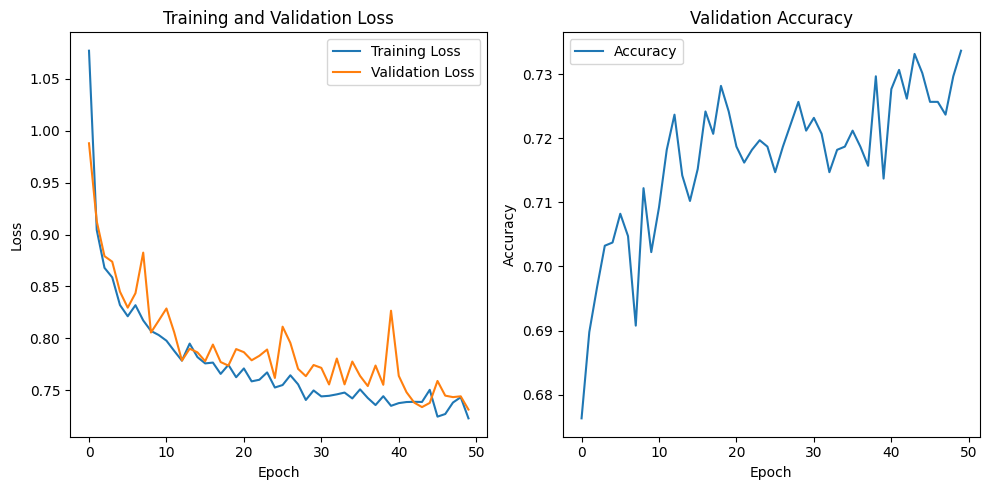

In [8]:
# Plotting the training progress
plt.figure(figsize=(10, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

c:\Users\Karolina\AppData\Local\Programs\Python\Python312\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
c:\Users\Karolina\AppData\Local\Programs\Python\Python312\Lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


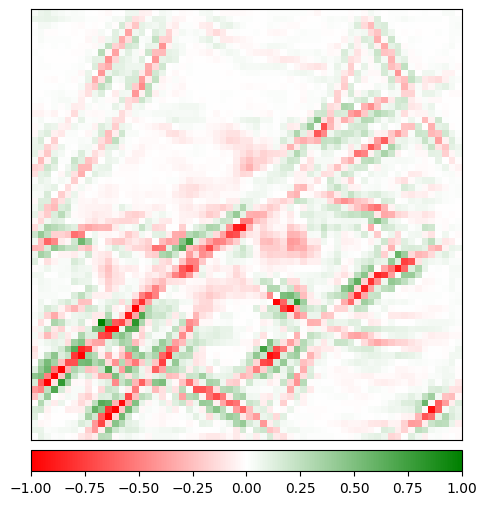

In [9]:
# 5. XAI: Grad-CAM dla DermaMNIST
layer = model.layer4[-1]
guided_gc = GuidedGradCam(model, layer)

# Wybierz próbkę testową
data, target = next(iter(test_loader))
data, target = data.to(device), target.to(device).squeeze().long()

# Grad-CAM dla pierwszej próbki
input_image = data[0].unsqueeze(0)  # Dodaj wymiar batcha
attributions = guided_gc.attribute(input_image, target=torch.argmax(model(input_image)).item())

# Wizualizacja Grad-CAM
grand_cam = viz.visualize_image_attr(
    np.transpose(attributions.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(data[0].cpu().numpy(), (1, 2, 0)),
    method="heat_map",
    sign="all",
    show_colorbar=True
)
